# Analyzer

Statistically, visually, and through machine learning compare mRNA and lncRNA sequences from GENCODE v38.

Assume the user downloaded files from GENCODE v38 [FTP](http://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_38/)
to a subdirectory called data.

## Import Dependencies


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import gzip
from scipy.stats import chisquare, kstest
import sys

from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Flatten,TimeDistributed
from keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
      f.write(s.text)  # writes to cloud local, delete the file later?
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/GenCodeTools.py')
    with open ('GenCodeTools.py', 'w') as f:
      f.write(s.text)
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/plot_generator.py')
    with open('plot_generator.py', 'w') as f:
      f.write(s.text)
    s = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
      f.write(s.text)  
    from KmerTools import KmerTools
    from RNA_describe import *
    from GenCodeTools import *
    from plot_generator import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='../data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_describe import *
    from SimTools.GenCodeTools import *
    from SimTools.plot_generator import *
    from SimTools.KmerTools import KmerTools

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_describe():
    print("ERROR: Cannot use RNA_describe.")

On Google CoLab, mount cloud-local file, get our code from GitHub.
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Load GENCODE Data
Loads GENCODE v38 data.

Filters out mRNA sequences based on UTR check.

In [2]:
PC_FILENAME='gencode.v38.pc_transcripts.fa.gz'
NC_FILENAME='gencode.v38.lncRNA_transcripts.fa.gz'
PC_FULLPATH=DATAPATH+PC_FILENAME
NC_FULLPATH=DATAPATH+NC_FILENAME
loader=GenCodeLoader()
loader.set_label(1)
loader.set_check_list(None) 
loader.set_check_utr(True)
pcdf=loader.load_file(PC_FULLPATH)
print("PC seqs loaded:",len(pcdf))
loader.set_label(0)
loader.set_check_list(None)
loader.set_check_utr(False)
ncdf=loader.load_file(NC_FULLPATH)
print("NC seqs loaded:",len(ncdf))

PC seqs loaded: 70825
NC seqs loaded: 48752


## Process Sequences


Generate Sample of GENCODE Data Set

Apply Length Constraints

Validate Sequences

In [3]:
APPLY_SUBSET = True             #Option to subset the data
MINIMUM_SEQUENCE_LENGTH = 200   #Minimum exclusive length to filter out sequences by
MAXIMUM_SEQUENCE_LENGTH = 4000  #Maximum inclusive length to filter out sequences by
SAMPLE_FRACTION = 1             #What fraction of the GenCode data set to take a sample of
REPRODUCABILITY_SEED = 314159   #Use to reproduce random sampling

In [4]:
if APPLY_SUBSET:
    pcdf = pcdf.sample(frac=SAMPLE_FRACTION, random_state=REPRODUCABILITY_SEED)
    ncdf = ncdf.sample(frac=SAMPLE_FRACTION, random_state=REPRODUCABILITY_SEED)

    print('PC sample size:', len(pcdf))
    print('NC sample size:', len(ncdf))

PC sample size: 70825
NC sample size: 48752


Apply Length Constraints

In [5]:
def subset_list_by_len_bounds(input_list, min_len, max_len):
  return list(filter(lambda x: len(x) > min_len and len(x) <= max_len, input_list))

In [6]:
pc_sequences = pcdf['sequence'].tolist()
nc_sequences = ncdf['sequence'].tolist()

if APPLY_SUBSET:
    pc_sequences = subset_list_by_len_bounds(pc_sequences, MINIMUM_SEQUENCE_LENGTH, MAXIMUM_SEQUENCE_LENGTH)
    nc_sequences = subset_list_by_len_bounds(nc_sequences, MINIMUM_SEQUENCE_LENGTH, MAXIMUM_SEQUENCE_LENGTH)

    print('PC seqs in length range','('+str(MINIMUM_SEQUENCE_LENGTH),'-',str(MAXIMUM_SEQUENCE_LENGTH)+'):', len(pc_sequences))
    print('NC seqs in length range','('+str(MINIMUM_SEQUENCE_LENGTH),'-',str(MAXIMUM_SEQUENCE_LENGTH)+'):', len(nc_sequences))

#Garbage collection
pcdf = None
ncdf = None

PC seqs in length range (200 - 4000): 55381
NC seqs in length range (200 - 4000): 46912


Validate Sequences

In [7]:
def valid_sequence(seq):
    """
    Checks if the given sequences if valid.
    """
    for chr in seq:
        if not (chr == 'A' or chr == 'C' or chr == 'G' or chr == 'T'):
            return False
    return True

def validate_sequences(sequences):
    """
    Validate the given list of sequences
    """
    i = 0
    while i < len(sequences):
        if valid_sequence(sequences[i]):
            i += 1
        else:
            sequences.remove(sequences[i])

validate_sequences(pc_sequences)
validate_sequences(nc_sequences)

print('Valid PC seqs:', len(pc_sequences))
print('Valid NC seqs:', len(nc_sequences))

Valid PC seqs: 55381
Valid NC seqs: 46911


## Set Up MLP

In [8]:
RATIO_TRAIN_TO_TEST = 0.99
INPUT_SHAPE = (None, 4**3 + 4**2 + 4**1)
MAX_K = 3
NEURONS = 16
DROP_RATE = 0.1
EPOCHS = 500
SPLITS = 5
FOLDS = 1

Define what is training data and what is testing data

In [9]:
NUM_PC = len(pc_sequences)
NUM_PC_TRAIN = int(NUM_PC * RATIO_TRAIN_TO_TEST)
NUM_NC = len(nc_sequences)
NUM_NC_TRAIN = int(NUM_NC * RATIO_TRAIN_TO_TEST)

pc_train = pc_sequences[:NUM_PC_TRAIN]
pc_test = pc_sequences[NUM_PC_TRAIN:]
nc_train = nc_sequences[:NUM_NC_TRAIN]
nc_test = nc_sequences[NUM_NC_TRAIN:]

print('PC TRAIN:', len(pc_train))
print('NC TRAIN', len(nc_train))
print('PC TEST:', len(pc_test))
print('NC TEST:', len(nc_test))

#Garbage Collection (this makes re-running the MLP a pain)
#pc_sequences = None
#nc_sequences = None

PC TRAIN: 54827
NC TRAIN 46441
PC TEST: 554
NC TEST: 470


Prepare the Inputs and the Labels

In [10]:
def prepare_x_and_y(seqs1, seqs0):
    """
    From Miller's MLP_GenCode_1??.
    """
    len1=len(seqs1)
    len0=len(seqs0)
    total=len1+len0
    L1=np.ones(len1,dtype=np.int8)
    L0=np.zeros(len0,dtype=np.int8)
    S1 = np.asarray(seqs1)
    S0 = np.asarray(seqs0)
    all_labels = np.concatenate((L1,L0))
    all_seqs = np.concatenate((S1,S0))  
    for i in range(0,len0):
        all_labels[i*2] = L0[i]
        all_seqs[i*2] = S0[i]
        all_labels[i*2+1] = L1[i]
        all_seqs[i*2+1] = S1[i]
    return all_seqs,all_labels
Xseq, y = prepare_x_and_y(pc_train, nc_train)

In [11]:
def seqs_to_kmer_freqs(seqs, max_K):
    """
    From Miller's MLP_GenCode_1??.
    """
    tool = KmerTools()  # from SimTools
    collection = []
    for seq in seqs:
        counts = tool.make_dict_upto_K(max_K)
        # Last param should be True when using Harvester.
        counts = tool.update_count_one_K(counts, max_K, seq, True)
        # Given counts for K=3, Harvester fills in counts for K=1,2.
        counts = tool.harvest_counts_from_K(counts, max_K)
        fdict = tool.count_to_frequency(counts, max_K)
        freqs = list(fdict.values())
        collection.append(freqs)
    return np.asarray(collection)

Xfrq = seqs_to_kmer_freqs(Xseq, MAX_K)

#Garbage Collection
Xseq = None

## Make and Train MLP

In [12]:
def make_DNN():
    """
    From Miller's MLP_GenCode_1??.
    """
    dt=np.float32
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()

    dnn.add(Dense(NEURONS, activation="sigmoid", dtype=dt))  # relu doesn't work as well
    dnn.add(Dropout(DROP_RATE))

    dnn.add(Dense(NEURONS, activation="sigmoid", dtype=dt)) 
    dnn.add(Dropout(DROP_RATE))

    dnn.add(Dense(NEURONS, activation="sigmoid", dtype=dt))  # relu doesn't work as well
    dnn.add(Dropout(DROP_RATE))

    dnn.add(Dense(NEURONS, activation="sigmoid", dtype=dt)) 
    dnn.add(Dropout(DROP_RATE))

    dnn.add(Dense(1, activation="sigmoid", dtype=dt))  

    dnn.compile(optimizer='adam',    # adadelta doesn't work as well
        loss=BinaryCrossentropy(from_logits=False),
        metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE) 
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (None, 84)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                1360      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)        

In [13]:
def do_cross_validation(X,y):
    """
    From Miller's MLP_GenCode_1??.
    """
    cv_scores = []
    fold=0
    #mycallbacks = [ModelCheckpoint(
    #    filepath=MODELPATH, save_best_only=True, 
    #    monitor='val_accuracy', mode='max')]   
    # When shuffle=True, the valid indices are a random subset.
    splitter = KFold(n_splits=SPLITS, shuffle=True) 
    model = None
    for train_index, valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                epochs=EPOCHS, 
                verbose=1,  # ascii art while learning
                # callbacks=mycallbacks,   # called at end of each epoch
                validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()
    return model  # parameters at end of training

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/500
2532/2532 [==============================] - 21s 2ms/step - loss: 0.6905 - accuracy: 0.5371 - val_loss: 0.6264 - val_accuracy: 0.6611
Epoch 2/500
2532/2532 [==============================] - 5s 2ms/step - loss: 0.6334 - accuracy: 0.6538 - val_loss: 0.6151 - val_accuracy: 0.6717
Epoch 3/500
2532/2532 [==============================] - 5s 2ms/step - loss: 0.6225 - accuracy: 0.6651 - val_loss: 0.5989 - val_accuracy: 0.6852
Epoch 4/500
2532/2532 [==============================] - 5s 2ms/step - loss: 0.6040 - accuracy: 0.6824 - val_loss: 0.5684 - val_accuracy: 0.7144
Epoch 5/500
2532/2532 [==============================] - 5s 2ms/step - loss: 0.5846 - accuracy: 0.7004 - val_loss: 0.5477 - val_accuracy: 0.7293
Epoch 6/500
2532/2532 [==============================] - 5s 2ms/step - loss: 0.5742 - accuracy: 0.7070 - val_loss: 0.5419 - val_accuracy: 0.7395
Epoch 7/500
2532/2532 [==============================] - 5s 2ms/step - loss: 0.5653 - 

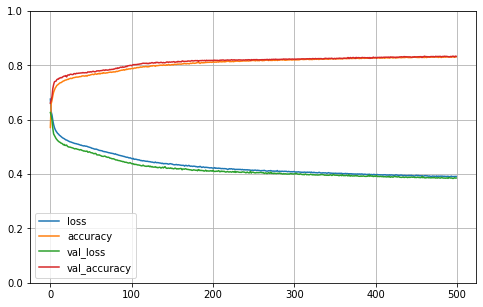

In [14]:
last_model = do_cross_validation(Xfrq, y)

## Show Results of MLP

In [15]:
def show_test_AUC(model, title, X, y):
    """
    From Miller's MLP_GenCode_1??.
    """
    ns_probs = [0 for _ in range(len(y))]
    bm_probs = model.predict(X)
    ns_auc = roc_auc_score(y, ns_probs)
    bm_auc = roc_auc_score(y, bm_probs)
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
    plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
    plt.title(title + ' ROC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print("%s: %.2f%%" %('AUC',bm_auc*100.0))
    
def show_test_accuracy(model,X,y):
    """
    From Miller's MLP_GenCode_1??.
    """
    scores = model.evaluate(X, y, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Accuracy on training data.
Prepare...
Extract K-mer features...
Plot...


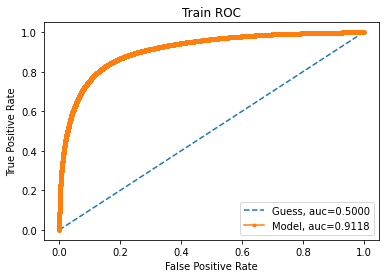

AUC: 91.18%
accuracy: 83.82%


In [16]:
print("Accuracy on training data.")
print("Prepare...")
X, y = prepare_x_and_y(pc_train, nc_train)
print("Extract K-mer features...")
X = seqs_to_kmer_freqs(X, MAX_K)
print("Plot...")
show_test_AUC(last_model, 'Train', X, y)
show_test_accuracy(last_model, X, y)

Accuracy on test data.
Prepare...
Extract K-mer features...
Plot...


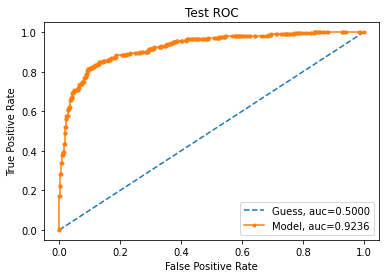

AUC: 92.36%
accuracy: 84.77%


In [17]:
print("Accuracy on test data.")
print("Prepare...")
X, y = prepare_x_and_y(pc_test, nc_test)
print("Extract K-mer features...")
X = seqs_to_kmer_freqs(X, MAX_K)
print("Plot...")
show_test_AUC(last_model, 'Test', X, y)
show_test_accuracy(last_model, X, y)